### Imports et Vérification GPU

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

# Vérifier GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.device_count())  # Devrait être 2 pour T4 x2

Using device: cuda
1


# Partie 1 - Régression avec NYSE

## 1. EDA pour NYSE

<class 'pandas.core.frame.DataFrame'>
Index: 42563 entries, 763664 to 413584
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    42563 non-null  datetime64[ns]
 1   symbol  42563 non-null  object        
 2   open    42563 non-null  float64       
 3   close   42563 non-null  float64       
 4   low     42563 non-null  float64       
 5   high    42563 non-null  float64       
 6   volume  42563 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.6+ MB
None
                                date          open         close  \
count                          42563  42563.000000  42563.000000   
mean   2013-07-18 18:45:15.541667584     70.269629     70.282952   
min              2010-01-04 00:00:00      0.980000      0.970000   
25%              2011-10-07 00:00:00     33.764999     33.779999   
50%              2013-08-02 00:00:00     52.699952     52.750000   
75%        

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


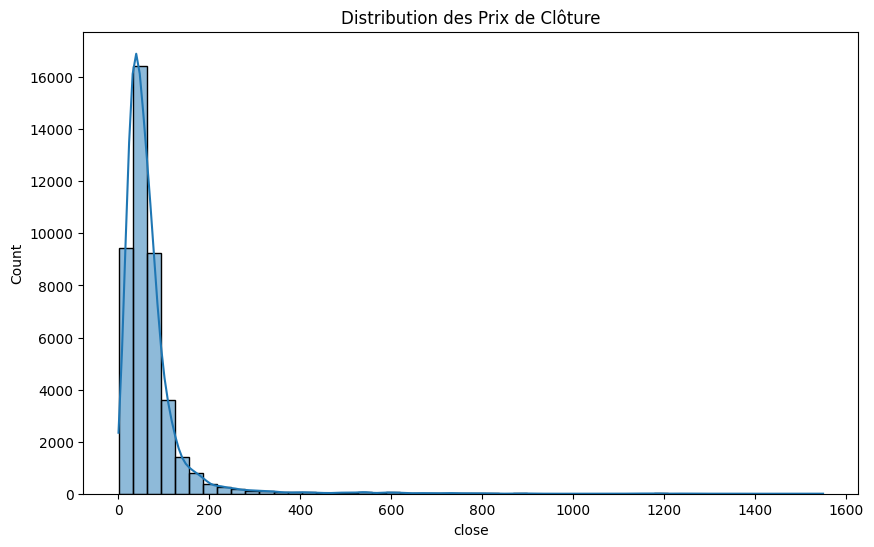

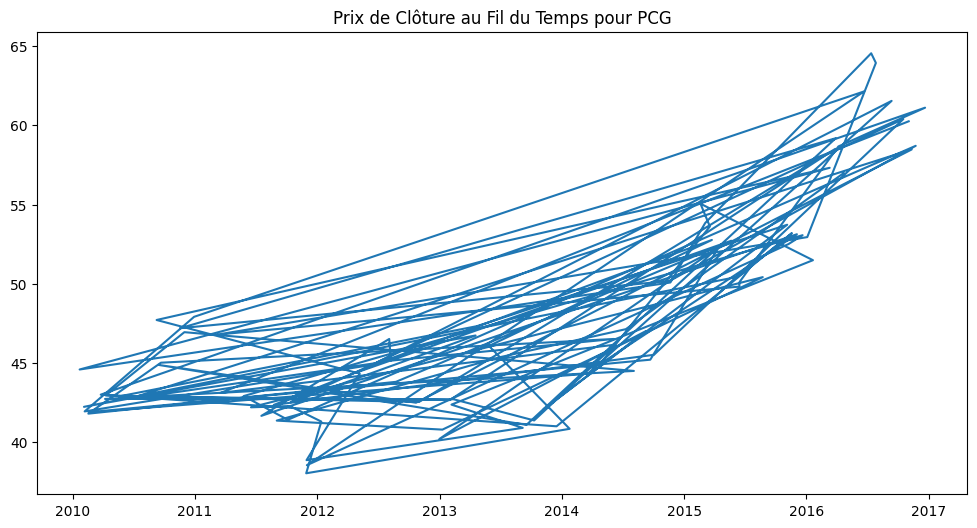

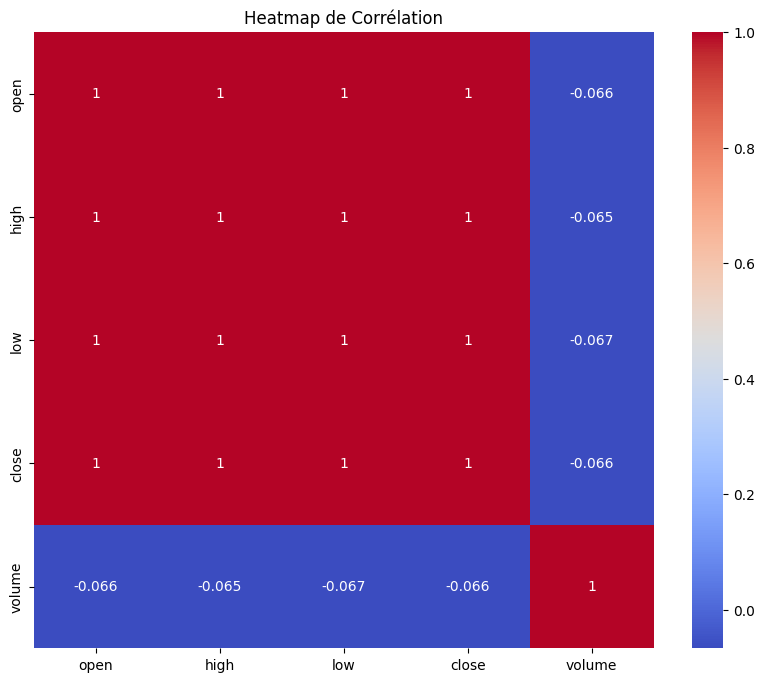

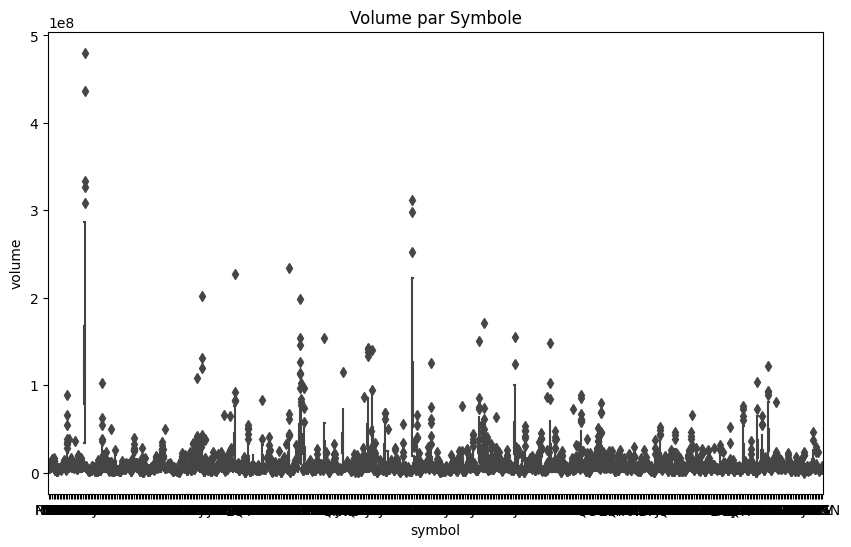

In [20]:
# Charger données
df_reg = pd.read_csv('/kaggle/input/tp1-data/prices.csv')
# Fix format date
df_reg['date'] = pd.to_datetime(df_reg['date'], format='mixed')

# Réduire taille pour vitesse (5%)
df_reg = df_reg.sample(frac=0.05, random_state=42)

# Infos
print(df_reg.info())
print(df_reg.describe())
print(df_reg['symbol'].value_counts())

# Valeurs manquantes
print(df_reg.isnull().sum())

# Visualisations
plt.figure(figsize=(10, 6))
sns.histplot(df_reg['close'], bins=50, kde=True)
plt.title('Distribution des Prix de Clôture')
plt.show()

plt.figure(figsize=(12, 6))
symbol_example = df_reg['symbol'].unique()[0]
df_symbol = df_reg[df_reg['symbol'] == symbol_example]
plt.plot(df_symbol['date'], df_symbol['close'])
plt.title(f'Prix de Clôture au Fil du Temps pour {symbol_example}')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df_reg[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap de Corrélation')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='symbol', y='volume', data=df_reg)
plt.title('Volume par Symbole')
plt.show()

## 2. Prétraitement et Dataset pour Régression

In [21]:
# Prétraitement
features = ['open', 'high', 'low', 'volume']
X_reg = df_reg[features].values
y_reg = df_reg['close'].values.reshape(-1, 1)

scaler_x_reg = MinMaxScaler()
scaler_y_reg = MinMaxScaler()
X_reg_scaled = scaler_x_reg.fit_transform(X_reg)
y_reg_scaled = scaler_y_reg.fit_transform(y_reg)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg_scaled, y_reg_scaled, test_size=0.2, random_state=42)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_reg = StockDataset(X_reg_train, y_reg_train)
test_dataset_reg = StockDataset(X_reg_test, y_reg_test)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=256, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=256, shuffle=False)

class RegressionMLP(nn.Module):
    def __init__(self, input_size=4, hidden_size1=64, hidden_size2=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

## 3. GridSearch pour Régression

In [22]:
class PyTorchRegressor(BaseEstimator):
    def __init__(self, lr=0.001, epochs=50, hidden_size1=64, hidden_size2=32):
        self.lr = lr
        self.epochs = epochs
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.device = device

    def fit(self, X, y):
        self.model = RegressionMLP(4, self.hidden_size1, self.hidden_size2).to(self.device)
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        dataset = StockDataset(X, y)
        loader = DataLoader(dataset, batch_size=256, shuffle=True)
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()
        return preds

param_grid_reg = {
    'lr': [0.001, 0.01],
    'epochs': [20, 50],
    'hidden_size1': [32, 64],
    'hidden_size2': [16, 32]
}
grid_reg = GridSearchCV(PyTorchRegressor(), param_grid_reg, cv=2, scoring='neg_mean_squared_error')
grid_reg.fit(X_reg_train, y_reg_train)

print("Meilleurs params régression :", grid_reg.best_params_)
best_model_reg = grid_reg.best_estimator_

Meilleurs params régression : {'epochs': 20, 'hidden_size1': 32, 'hidden_size2': 32, 'lr': 0.01}


## 4. Visualisation pour Régression

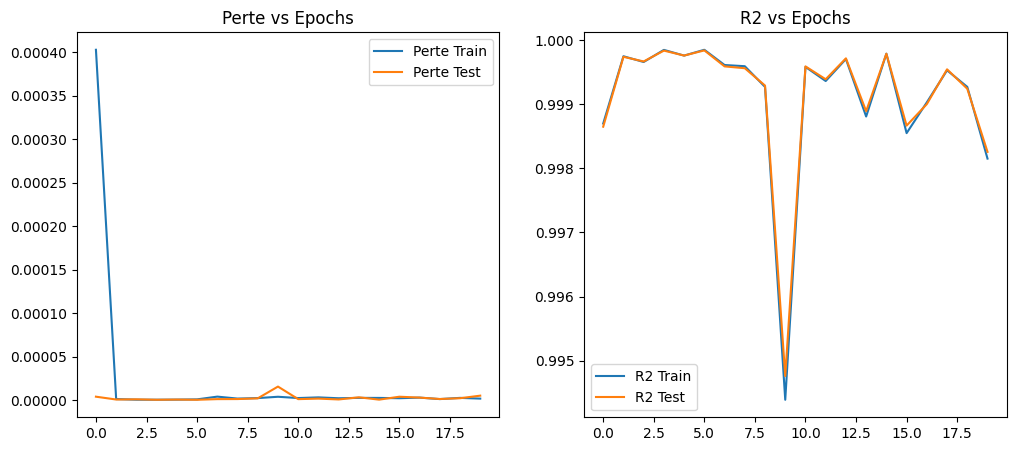

In [23]:
model_reg = RegressionMLP(4, grid_reg.best_params_['hidden_size1'], grid_reg.best_params_['hidden_size2']).to(device)
if torch.cuda.device_count() > 1:
    model_reg = nn.DataParallel(model_reg)

optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=grid_reg.best_params_['lr'])
criterion_reg = nn.MSELoss()

train_losses_reg = []
test_losses_reg = []
train_r2_reg = []
test_r2_reg = []

for epoch in range(grid_reg.best_params_['epochs']):
    model_reg.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader_reg:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_reg.zero_grad()
        outputs = model_reg(batch_X)
        loss = criterion_reg(outputs, batch_y)
        loss.backward()
        optimizer_reg.step()
        epoch_loss += loss.item()
    train_losses_reg.append(epoch_loss / len(train_loader_reg))

    model_reg.eval()
    with torch.no_grad():
        X_train_tensor = torch.tensor(X_reg_train, dtype=torch.float32).to(device)
        y_pred_train = model_reg(X_train_tensor).cpu().numpy()
        X_test_tensor = torch.tensor(X_reg_test, dtype=torch.float32).to(device)
        y_pred_test = model_reg(X_test_tensor).cpu().numpy()
        test_loss = mean_squared_error(y_reg_test, y_pred_test)
        test_losses_reg.append(test_loss)
        train_r2_reg.append(r2_score(y_reg_train, y_pred_train))
        test_r2_reg.append(r2_score(y_reg_test, y_pred_test))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_reg, label='Perte Train')
plt.plot(test_losses_reg, label='Perte Test')
plt.title('Perte vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_r2_reg, label='R2 Train')
plt.plot(test_r2_reg, label='R2 Test')
plt.title('R2 vs Epochs')
plt.legend()
plt.show()

## 5. Régularisation pour Régression

In [24]:
class RegularizedRegressionMLP(nn.Module):
    def __init__(self, input_size=4, hidden_size1=64, hidden_size2=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

model_reg_reg = RegularizedRegressionMLP(4, grid_reg.best_params_['hidden_size1'], grid_reg.best_params_['hidden_size2']).to(device)
if torch.cuda.device_count() > 1:
    model_reg_reg = nn.DataParallel(model_reg_reg)

optimizer_reg_reg = torch.optim.Adam(model_reg_reg.parameters(), lr=grid_reg.best_params_['lr'], weight_decay=0.01)

# Entraîner comme avant
train_losses_reg_reg = []
test_losses_reg_reg = []
train_r2_reg_reg = []
test_r2_reg_reg = []

for epoch in range(grid_reg.best_params_['epochs']):
    model_reg_reg.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader_reg:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_reg_reg.zero_grad()
        outputs = model_reg_reg(batch_X)
        loss = criterion_reg(outputs, batch_y)
        loss.backward()
        optimizer_reg_reg.step()
        epoch_loss += loss.item()
    train_losses_reg_reg.append(epoch_loss / len(train_loader_reg))

    model_reg_reg.eval()
    with torch.no_grad():
        y_pred_train = model_reg_reg(torch.tensor(X_reg_train, dtype=torch.float32).to(device)).cpu().numpy()
        y_pred_test = model_reg_reg(torch.tensor(X_reg_test, dtype=torch.float32).to(device)).cpu().numpy()
        test_loss = mean_squared_error(y_reg_test, y_pred_test)
        test_losses_reg_reg.append(test_loss)
        train_r2_reg_reg.append(r2_score(y_reg_train, y_pred_train))
        test_r2_reg_reg.append(r2_score(y_reg_test, y_pred_test))

# Comparaison
print("Base Model Test R2:", test_r2_reg[-1])
print("Regularized Model Test R2:", test_r2_reg_reg[-1])

Base Model Test R2: 0.9982562409305701
Regularized Model Test R2: -0.00021535888814083748


# Partie 2 - Classification Multi-Classe

## 1. Prétraitement pour Classification

In [25]:
print(df_cls.columns.tolist())

['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Failure Type', 'Type_L', 'Type_M']


In [26]:
# CHARGEMENT ET PRÉPARATION DES DONNÉES POUR LA CLASSIFICATION
df_cls = pd.read_csv('/kaggle/input/tp1-data/predictive_maintenance.csv')

# Nettoyage des données
df_cls.drop_duplicates(inplace=True)

# Remplir les valeurs manquantes
if df_cls.isnull().sum().sum() > 0:
    df_cls.fillna(method='ffill', inplace=True)

# Encodage de la colonne 'Type'
df_cls = pd.get_dummies(df_cls, columns=['Type'], drop_first=True)

# Supprimer les colonnes inutiles
columns_to_drop = ['UDI', 'Product ID', 'Target']
df_cls.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

# Normalisation des features numériques
numerical_cls = [
    'Air temperature [K]', 
    'Process temperature [K]', 
    'Rotational speed [rpm]', 
    'Torque [Nm]', 
    'Tool wear [min]'
]

scaler_cls = MinMaxScaler()
df_cls[numerical_cls] = scaler_cls.fit_transform(df_cls[numerical_cls])

# Séparation features et target
y_cls = df_cls['Failure Type']
X_cls = df_cls.drop(['Failure Type'], axis=1)

## 2. EDA pour Classification

       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean              0.511405                 0.531551                0.215818   
std               0.217419                 0.183177                0.104356   
min               0.000000                 0.000000                0.000000   
25%               0.326087                 0.382716                0.148428   
50%               0.521739                 0.543210                0.194994   
75%               0.673913                 0.666667                0.258440   
max               1.000000                 1.000000                1.000000   

        Torque [Nm]  Tool wear [min]  
count  10000.000000     10000.000000  
mean       0.497073         0.426684  
std        0.136936         0.251597  
min        0.000000         0.000000  
25%        0.403846         0.209486  
50%        0.498626         0.426877  
75%        0.59

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


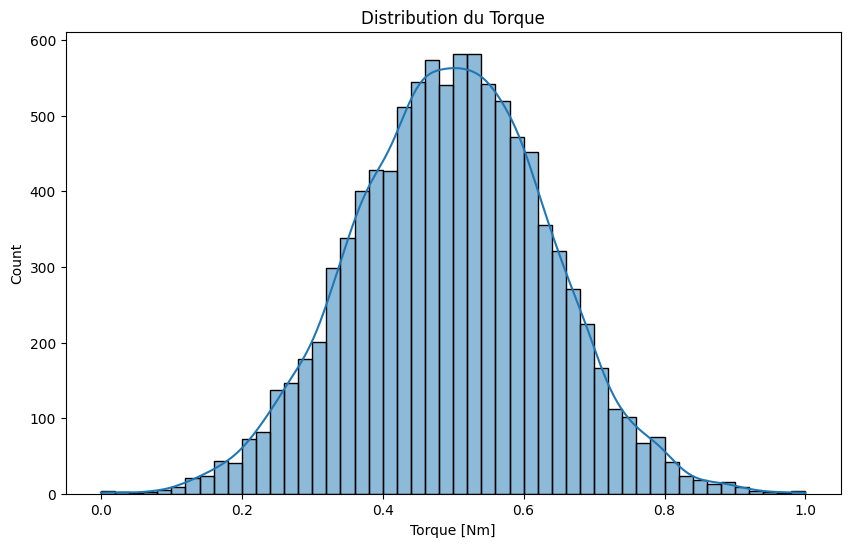

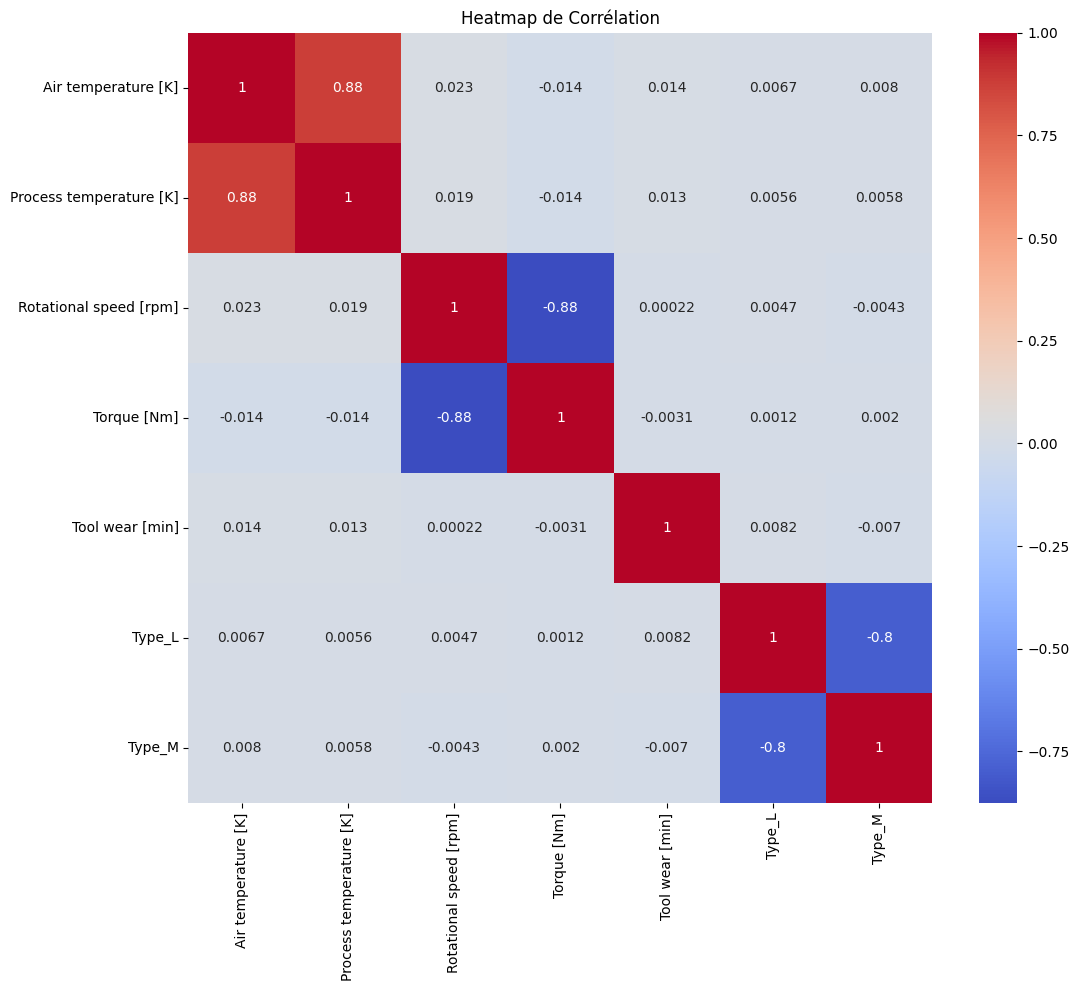

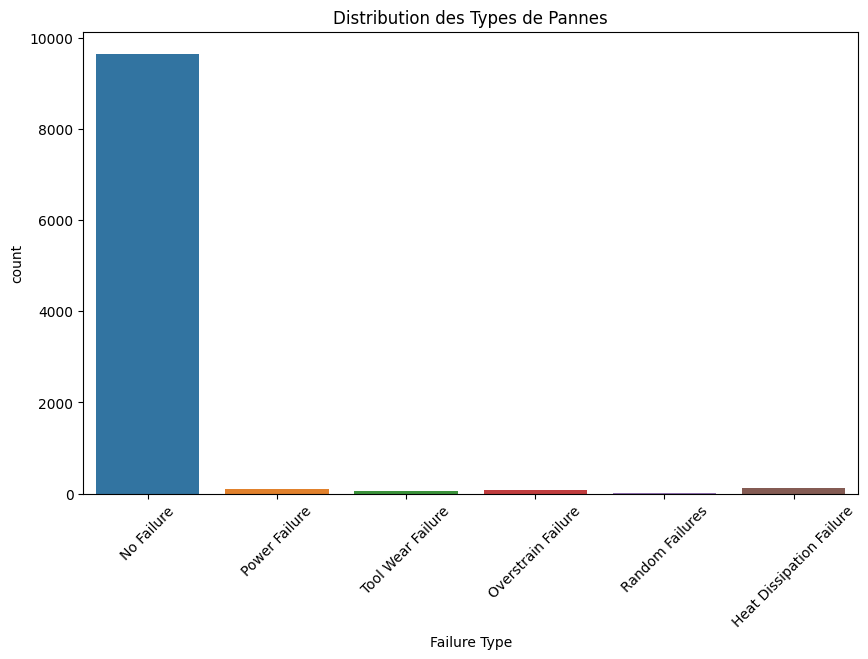

In [27]:
print(df_cls.describe())
print(df_cls['Failure Type'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(df_cls['Torque [Nm]'], bins=50, kde=True)
plt.title('Distribution du Torque')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df_cls.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap de Corrélation')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Failure Type', data=df_cls)
plt.title('Distribution des Types de Pannes')
plt.xticks(rotation=45)
plt.show()

## 3. Augmentation pour Équilibre

In [28]:
smote = SMOTE(random_state=42)
X_cls_resampled, y_cls_resampled = smote.fit_resample(X_cls, y_cls)
print(y_cls_resampled.value_counts())

Failure Type
No Failure                  9652
Power Failure               9652
Tool Wear Failure           9652
Overstrain Failure          9652
Random Failures             9652
Heat Dissipation Failure    9652
Name: count, dtype: int64


## 4. Dataset et Architecture pour Classification

In [31]:
from sklearn.preprocessing import LabelEncoder

# Encoder y_cls_resampled
le = LabelEncoder()
y_cls_resampled_encoded = le.fit_transform(y_cls_resampled)

# Convertir X_cls_resampled en numpy array numérique
X_cls_resampled = X_cls_resampled.astype(float).values

# Split train/test
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls_resampled, 
    y_cls_resampled_encoded, 
    test_size=0.2, 
    random_state=42
)

class ClassDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_cls = ClassDataset(X_cls_train, y_cls_train)
test_dataset_cls = ClassDataset(X_cls_test, y_cls_test)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=256, shuffle=True)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=256, shuffle=False)

class ClassificationMLP(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_classes=6):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

## 5. GridSearch pour Classification

In [33]:
class PyTorchClassifier(BaseEstimator):
    def __init__(self, lr=0.001, epochs=50, hidden_size1=64, hidden_size2=32):
        self.lr = lr
        self.epochs = epochs
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.device = device

    def fit(self, X, y):
        num_classes = len(np.unique(y))
        self.model = ClassificationMLP(X.shape[1], self.hidden_size1, self.hidden_size2, num_classes).to(self.device)
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        dataset = ClassDataset(pd.DataFrame(X), y)
        loader = DataLoader(dataset, batch_size=256, shuffle=True)
        for epoch in range(self.epochs):
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
        return preds

param_grid_cls = {
    'lr': [0.001, 0.01],
    'epochs': [20, 50],
    'hidden_size1': [32, 64],
    'hidden_size2': [16, 32]
}
grid_cls = GridSearchCV(PyTorchClassifier(), param_grid_cls, cv=2, scoring='accuracy')
grid_cls.fit(X_cls_train, y_cls_train)

print("Meilleurs params classification :", grid_cls.best_params_)
best_model_cls = grid_cls.best_estimator_

Meilleurs params classification : {'epochs': 50, 'hidden_size1': 64, 'hidden_size2': 32, 'lr': 0.01}


## 6. Visualisation pour Classification

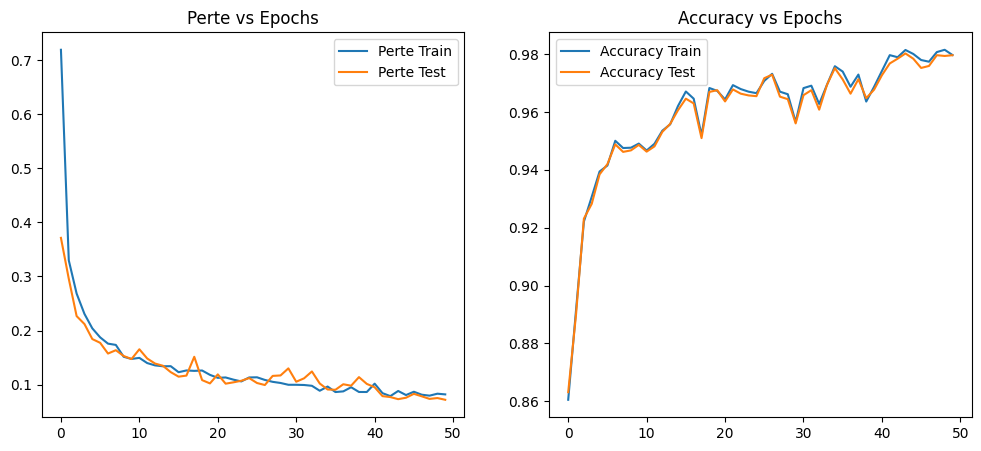

In [35]:
model_cls = ClassificationMLP(X_cls_train.shape[1], grid_cls.best_params_['hidden_size1'], grid_cls.best_params_['hidden_size2'], len(le.classes_)).to(device)
if torch.cuda.device_count() > 1:
    model_cls = nn.DataParallel(model_cls)
optimizer_cls = torch.optim.Adam(model_cls.parameters(), lr=grid_cls.best_params_['lr'])
criterion_cls = nn.CrossEntropyLoss()

train_losses_cls = []
test_losses_cls = []
train_acc_cls = []
test_acc_cls = []

for epoch in range(grid_cls.best_params_['epochs']):
    model_cls.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader_cls:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_cls.zero_grad()
        outputs = model_cls(batch_X)
        loss = criterion_cls(outputs, batch_y)
        loss.backward()
        optimizer_cls.step()
        epoch_loss += loss.item()
    train_losses_cls.append(epoch_loss / len(train_loader_cls))
    
    model_cls.eval()
    with torch.no_grad():
        X_train_tensor = torch.tensor(X_cls_train, dtype=torch.float32).to(device)
        y_pred_train = torch.argmax(model_cls(X_train_tensor), dim=1).cpu().numpy()
        X_test_tensor = torch.tensor(X_cls_test, dtype=torch.float32).to(device)
        y_pred_test = torch.argmax(model_cls(X_test_tensor), dim=1).cpu().numpy()
        test_loss_tensor = model_cls(X_test_tensor)
        test_loss = criterion_cls(test_loss_tensor, torch.tensor(y_cls_test).to(device)).item()
        test_losses_cls.append(test_loss)
        train_acc_cls.append(accuracy_score(y_cls_train, y_pred_train))
        test_acc_cls.append(accuracy_score(y_cls_test, y_pred_test))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_cls, label='Perte Train')
plt.plot(test_losses_cls, label='Perte Test')
plt.title('Perte vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_cls, label='Accuracy Train')
plt.plot(test_acc_cls, label='Accuracy Test')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

## 7. Métriques pour Classification

In [37]:
y_pred_train_cls = le.inverse_transform(best_model_cls.predict(X_cls_train))
y_pred_test_cls = le.inverse_transform(best_model_cls.predict(X_cls_test))

print("Rapport Train :\n", classification_report(le.inverse_transform(y_cls_train), y_pred_train_cls))
print("Rapport Test :\n", classification_report(le.inverse_transform(y_cls_test), y_pred_test_cls))

Rapport Train :
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.99      1.00      0.99      7771
              No Failure       0.91      0.93      0.92      7690
      Overstrain Failure       1.00      0.99      0.99      7719
           Power Failure       0.99      1.00      1.00      7695
         Random Failures       0.98      0.92      0.95      7736
       Tool Wear Failure       0.97      1.00      0.98      7718

                accuracy                           0.97     46329
               macro avg       0.97      0.97      0.97     46329
            weighted avg       0.97      0.97      0.97     46329

Rapport Test :
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.99      1.00      0.99      1881
              No Failure       0.91      0.92      0.91      1962
      Overstrain Failure       1.00      0.98      0.99      1933
           Power Failure       0.99    

## 8. Régularisation pour Classification

In [39]:
class RegularizedClassificationMLP(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, num_classes=6):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

model_reg_cls = RegularizedClassificationMLP(X_cls_train.shape[1], grid_cls.best_params_['hidden_size1'], grid_cls.best_params_['hidden_size2'], len(le.classes_)).to(device)
if torch.cuda.device_count() > 1:
    model_reg_cls = nn.DataParallel(model_reg_cls)

optimizer_reg_cls = torch.optim.Adam(model_reg_cls.parameters(), lr=grid_cls.best_params_['lr'], weight_decay=0.01)

# Entraîner comme avant
# (Répétez la boucle pour model_reg_cls, enregistrez losses/acc)

# Comparaison métriques
y_pred_test_reg_cls = le.inverse_transform(torch.argmax(model_reg_cls(torch.tensor(X_cls_test, dtype=torch.float32).to(device)), dim=1).cpu().numpy())
print("Regularized Test Report :\n", classification_report(le.inverse_transform(y_cls_test), y_pred_test_reg_cls))

Regularized Test Report :
                           precision    recall  f1-score   support

Heat Dissipation Failure       0.00      0.00      0.00      1881
              No Failure       0.19      0.28      0.23      1962
      Overstrain Failure       0.14      0.24      0.18      1933
           Power Failure       0.17      0.38      0.24      1957
         Random Failures       0.00      0.00      0.00      1916
       Tool Wear Failure       0.18      0.11      0.13      1934

                accuracy                           0.17     11583
               macro avg       0.11      0.17      0.13     11583
            weighted avg       0.12      0.17      0.13     11583



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Désinstaller et réinstaller avec des versions compatibles
# !pip uninstall -y scikit-learn imbalanced-learn
# !pip install scikit-learn==1.4.2 imbalanced-learn==0.12.0